In [444]:
setwd('/home/other/jpf5265/DnDs-visualization/test_dataset/')

In [445]:
library(tidyverse)
library(viridis)
library(patchwork)
library(ggraph)
library(igraph)
library(RColorBrewer)

In [446]:
library(dplyr)
# Load the datasets
taxonomy <- read.csv('marinus_taxonomy.csv')
dnds <- read.csv('dnds_constant_15.csv')

# Drop rows where column dNdS_ratio or column dNdS_ratio_constant is NA
dnds <- dnds %>%
  filter(!is.na(dNdS_ratio) & !is.na(dNdS_ratio_constant)) %>%
  select(X, A, B, dNdS_ratio_constant)

In [447]:
# Add a root column to the taxonomy data, reshape the data into long format
taxonomy_long <- taxonomy %>%
  select(custom_fasta_name, phylum, class, order, family, genus, species) %>%
  mutate(Root = "Root") %>%

  # Create hierarchical relationships
  pivot_longer(cols = c(Root, phylum, class, order, family, genus, species, custom_fasta_name),
               names_to = "level",
               values_to = "name")%>%
  mutate(genome_id = rep(taxonomy$custom_fasta_name, each = 8))


# Create hierarchical relationships
hierarchy <- taxonomy_long %>%

  # sorting taxomomic lelvel within each genome ("genome_id")
  arrange(genome_id, match(level, c("Root", "phylum", "class", "order", "family", "genus", "species", "custom_fasta_name"))) %>%
  group_by(genome_id) %>%

  # from = lag(name): Take the value from the previous row in the column "name" and assigns it to a new column called from, 
  # to = name: Set the value in column "to" the value in the name column.
  mutate(from = lag(name), to = name)  %>%
  filter(!is.na(from)) %>%
  select(from, to) %>%
  distinct() %>%
  ungroup() %>%
  distinct(from, to)

Adding missing grouping variables: `genome_id`


In [448]:
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))))
# Count the number of vertices so that we can generates the same numbers of random values uniformly distributed between 0 and 1
nrow(vertices)

[1] 31

In [449]:
set.seed(399)
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))), value = runif(31)) 


connect <- dnds %>%
  rename(from = A, to = B, dndsvalue = dNdS_ratio_constant) %>%
  select(from, to, dndsvalue) 

# Generate a new column called new_dndsvalue with the average value for each reciprocal pair of genomes
connect$new_dndsvalue <- ave(
  connect$dndsvalue,
  pmin(connect$from, connect$to),  # Ensures 'from' and 'to' are treated symmetrically
  pmax(connect$from, connect$to),
  FUN = function(x) mean(x)
)


from <- match( connect$from, vertices$name)
to <- match( connect$to, vertices$name)

# Create a graph object
mygraph <- graph_from_data_frame(hierarchy, vertices = vertices)

# create the layout so we can feed to to get_con and manipulate the data frame directly for plotting
layout_data <- create_layout(mygraph, layout = 'dendrogram', circular = TRUE)
# 'from' and 'to' are your vectors of node indices or names
conn_function <- get_con(from = from, to = to)
conn_data_frame <- conn_function(layout_data)
# conn_data_frame<-conn_data_frame[conn_data_frame$name %in% c("P.AS9601", "S.CC9311"),]

# # Add connection values to `conn_data_frame`. This is one of the key steps of getting the connections/dNdS values to match up with the actual plot
conn_data_frame$con.value <- connect$new_dndsvalue[conn_data_frame$con.id]


In [450]:
# Determine the coordinates of the genus label
genome_coordinate<-unique(conn_data_frame[conn_data_frame$leaf == TRUE, c('name','x','y')])

genome_coordinate_info <- merge(
  genome_coordinate, 
  taxonomy[, c("custom_fasta_name", "phylum", "class", "order", "family", "genus", "species")],
  by.x = "name", 
  by.y = "custom_fasta_name", 
  all.x = TRUE
)


# Function to calculate center coordinates for each genus
calculate_genus_centers <- function(data, genus_column, x_column, y_column) {
  # Group by genus and calculate the mean x and y coordinates
  centers <- data %>%
    group_by(!!sym(genus_column)) %>%
    summarise(
      center_x = mean(!!sym(x_column)),
      center_y = mean(!!sym(y_column)),
      .groups = 'drop'
    )
  return(centers)
}

# Example usage
# Assuming your dataframe is named `species_data` and has columns: "genus", "x", "y"
# Replace 'genus', 'x', 'y' with the actual column names in your dataset
genus_centers <- calculate_genus_centers(genome_coordinate_info, genus_column = "genus", x_column = "x", y_column = "y")
genus_centers


genus,center_x,center_y
<chr>,<dbl>,<dbl>
Prochlorococcus,0.5314401,-0.1212977
Synechococcus,-0.7085868,0.1617303


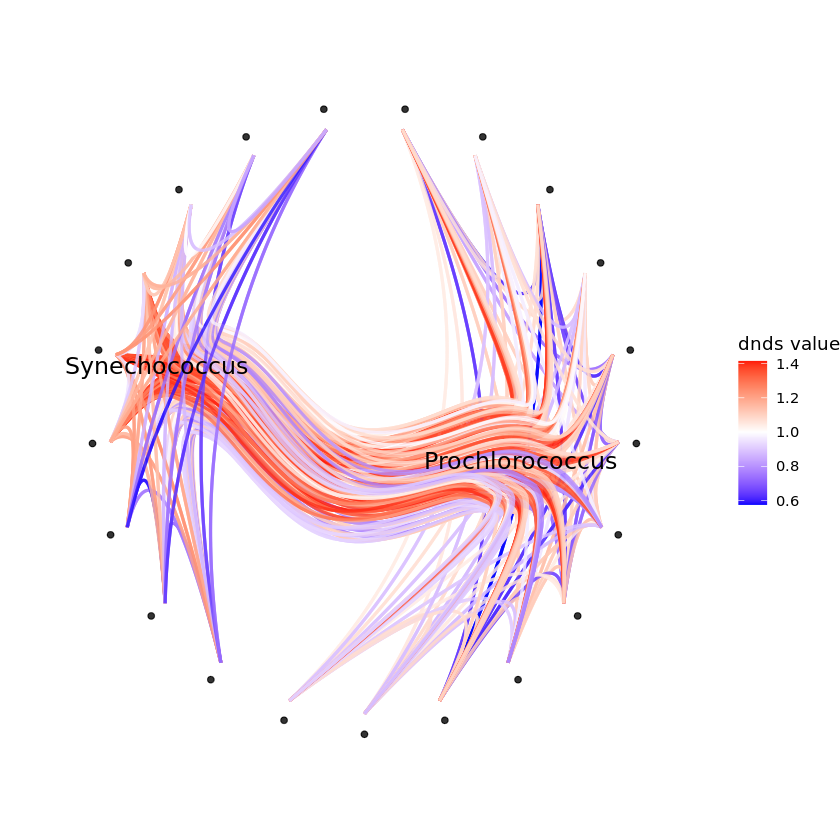

In [451]:
# plot everything. Use a toy gradient for convenience in tracking that the edge colors match with the connect/dNdS values
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +  # Adjust edge colors based on `con.value`
  geom_text(
    data = genus_centers,  # Use the genus_centers dataframe
    aes(
      x = center_x * 1.15,  # Adjust x for genus labels
      y = center_y * 1.15,  # Adjust y for genus labels
      label = genus         # Use the genus column for labels
    ),
    size = 5, 
    alpha = 1
  ) +  # Remove color from points
  geom_node_point(
    aes(
      filter = leaf, 
      x = x * 1.07, 
      y = y * 1.07
    ), 
    alpha = 0.8
  ) +  # Remove color from points
  scale_edge_colour_gradient2(
    low = "blue",    # Blue for negative values
    mid = "white",  # White for zero
    high = "red",  # Red for positive values
    midpoint = 1,  # Center of gradient
    name = "dnds value"
    
  ) +
  scale_size_continuous(range = c(1, 3)) +  # Size scale for node points
  theme_void() +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))